In [1]:
%load_ext autoreload
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import ctypes
import time
import pysoem
import importlib
from helpers.EPOS4 import *
from helpers.position_camera_helpers import *
%aimport helpers.EPOS4
%aimport helpers.position_camera_helpers
%autoreload 1
import logging
from typing import NamedTuple

In [2]:
# Set up logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('EPOS4_repeatability_and_longevity_tests.log')
fh.setLevel(logging.DEBUG)
# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to logger
logger.addHandler(fh)
logger.addHandler(ch)

# Setup and Home Each Slit

In [3]:
# Set up pysoem
if_offset = 4
ifname = pysoem.find_adapters()[if_offset].name
master = None
try:
    master = pysoem.Master(ifname)
    master.close()
    master.open(ifname)
    if master.config_init() > 0:
        logging.info("Found {} slaves".format(len(master.slaves)))
        for slave in master.slaves:
            slave.recover()
            logging.info("Found {} with Product ID {}".format(slave.name, slave.id))
    else:
        logging.error("No slaves found!")
        
except OSError as e:
    logging.error("Error while finding slaves: %s" % e)

2023-09-06 13:26:50,009 - root - INFO - Found 5 slaves
2023-09-06 13:26:50,010 - root - INFO - Found EPOS4 with Product ID 1766850560
2023-09-06 13:26:50,010 - root - INFO - Found EPOS4 with Product ID 1766850560
2023-09-06 13:26:50,011 - root - INFO - Found EPOS4 with Product ID 1766850560
2023-09-06 13:26:50,011 - root - INFO - Found EPOS4 with Product ID 1766850560
2023-09-06 13:26:50,011 - root - INFO - Found EPOS4 with Product ID 1766850560


In [19]:
master.close()

In [4]:
# Home each slave if the encoder has already been calibrated
for slave in master.slaves:
    logging.info("Homing %s" % slave.name)
    home_slave_using_current_ssi_position(slave)

2023-09-06 13:26:52,093 - root - INFO - Homing EPOS4
2023-09-06 13:26:53,311 - root - INFO - home_slave: homing successful with absolute position: 1967
2023-09-06 13:26:53,311 - root - INFO - Homing EPOS4
2023-09-06 13:26:54,425 - root - INFO - home_slave: homing successful with absolute position: 1218
2023-09-06 13:26:54,426 - root - INFO - Homing EPOS4
2023-09-06 13:26:55,545 - root - INFO - home_slave: homing successful with absolute position: 403
2023-09-06 13:26:55,545 - root - INFO - Homing EPOS4
2023-09-06 13:26:56,658 - root - INFO - home_slave: homing successful with absolute position: 262
2023-09-06 13:26:56,658 - root - INFO - Homing EPOS4
2023-09-06 13:26:57,769 - root - INFO - home_slave: homing successful with absolute position: 0


In [5]:
move_value = -5000
slave = master.slaves[0]
logging.info("Moving %s by %d" % (slave.name, move_value))
current_position = get_position_actual_value(slave)
clear_faults(slave)
set_position_using_csp_mode(slave, current_position + move_value)

2023-09-06 13:18:30,983 - root - INFO - Moving EPOS4 by -5000


# Set up camera and take reference image

In [6]:
# Set up the camera
WEBCAM_INDEX = 0
ROT_ANG = 0
camera = open_webcam_ueye(WEBCAM_INDEX)


2023-09-01 14:31:11,428 - root - INFO - Camera model: UI149xLE-M
2023-09-01 14:31:11,429 - root - INFO - Camera serial no.: 4103218478
2023-09-01 14:31:11,429 - root - INFO - Maximum image width: 3840
2023-09-01 14:31:11,429 - root - INFO - Maximum image height: 2748


In [11]:
close_camera(camera)

### Camera view of trackers

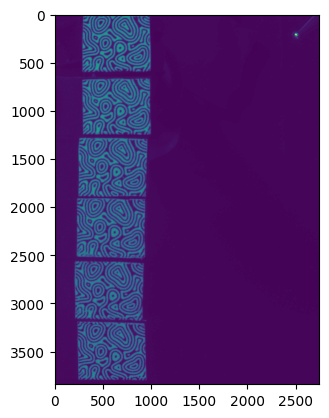

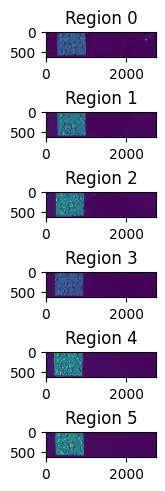

In [7]:
# get original tracker image for each slit
NUMBER_OF_SLITS = 6

class frame_bounds(NamedTuple):
    x1: int = 80
    y1: int = 600
    x2: int = 2800
    y2: int = 2200

bounds = frame_bounds()
bounds = None

GAP_HEIGHT = 100
test_frame = get_frame(camera, bounds, ROT_ANG)
plt.imshow(test_frame)
plt.show()
cv2.imwrite("test_frame.png", test_frame)

regions = get_n_regions(test_frame, NUMBER_OF_SLITS, True)

### Pixels to um conversion

By taking a picture of a ruler in the same focal plane as the registration targets, we can compute the number of microns per pixel. The image shown below allows for pixels to be counted and results in a calibration value of approximately 23 microns per pixel.

<div>
<img src="calibration.png" width="500"/>
</div>

In [5]:
# convert pixels to um
UM_PER_PIXEL = 17
PEAK_WIDTH = 39

def p_to_um(p):
    return p*UM_PER_PIXEL

In [6]:
# get current offset of each slit
GAP_HEIGHT = 100
frame = get_frame(camera, bounds, ROT_ANG)
plt.imshow(frame)
plt.show()
cv2.imwrite("test_frame.png", test_frame)

regions = get_n_regions(frame, NUMBER_OF_SLITS, True)
print("Region shapes: {}".format([r.shape for r in regions]))
get_pixel_shift_n_regions(regions[0], regions, peak_width=PEAK_WIDTH, display=True)

NameError: name 'camera' is not defined

### Use camera to align the slits

In [7]:
VELOCITY = 1500
ACCELERATION = 500

In [48]:
OFFSET_LIMIT = 0.3
slaves = master.slaves
# slaves = slaves[::-1]

for i in range(len(master.slaves)):
    slave = slaves[i]
    
    # get difference between top and bottom regions
    frame = get_frame(camera, bounds, ROT_ANG)
    regions = get_n_regions(frame, NUMBER_OF_SLITS, False)
    offset = get_pixel_shift_n_regions(regions[0], regions, peak_width=PEAK_WIDTH, display=False)[i + 1]
    logger.info("Offset (X, Y): {}".format(offset))
    
    while (abs(offset[0]) > OFFSET_LIMIT):
        # Move each slave to try and align
        move_value = int(10*offset[0])
        if (i == 4):
            move_value = int(100*offset[0])
        clear_faults(slave)
        current_position = get_position_actual_value(slave)
        logging.info("{}: Moving from {} to {}".format(i, current_position, current_position+move_value))
        set_position_using_ppm_mode(slave, current_position+move_value, VELOCITY, ACCELERATION, True)

        time.sleep(2)

        # get difference between top and bottom regions
        frame = get_frame(camera, bounds, ROT_ANG)
        regions = get_n_regions(frame, NUMBER_OF_SLITS, False)
        offset = get_pixel_shift_n_regions(regions[0], regions, peak_width=PEAK_WIDTH, display=False)[i + 1]
        logger.info("{}: Offset (X, Y): {}".format(i, offset))

        regions = get_n_regions(frame, NUMBER_OF_SLITS, False)


2023-08-30 11:42:05,731 - root - INFO - Offset (X, Y): (66.02026987361069, -28.097821734609454)
2023-08-30 11:42:07,779 - root - INFO - 0: Moving from 221266 to 221926
2023-08-30 11:42:12,062 - root - INFO - 0: Offset (X, Y): (53.15858292896337, -28.147284512789668)
2023-08-30 11:42:14,087 - root - INFO - 0: Moving from 221885 to 222416
2023-08-30 11:42:18,375 - root - INFO - 0: Offset (X, Y): (20.88326103664508, -28.207765703638074)
2023-08-30 11:42:20,416 - root - INFO - 0: Moving from 222394 to 222602
2023-08-30 11:42:24,691 - root - INFO - 0: Offset (X, Y): (0.49615130436041, -28.295427241607115)
2023-08-30 11:42:26,735 - root - INFO - 0: Moving from 222593 to 222597
2023-08-30 11:42:31,017 - root - INFO - 0: Offset (X, Y): (-4.327976172775607, -28.314012891315258)
2023-08-30 11:42:33,059 - root - INFO - 0: Moving from 222597 to 222554
2023-08-30 11:42:37,351 - root - INFO - 0: Offset (X, Y): (-3.9698702356447484, -28.311617375171522)
2023-08-30 11:42:39,397 - root - INFO - 0: Movi

In [85]:
# Just a snippet for free-moving a bar

move_value = 5000
slave = master.slaves[0]
logging.info("Moving %s by %d" % (slave.name, move_value))
current_position = 21742
clear_faults(slave)
set_position_using_ppm_mode(slave, current_position, VELOCITY, ACCELERATION, True)
time.sleep(5)
logging.info("Original position was {}. Current position is {}".format(current_position, get_position_actual_value(slave)))

2023-09-06 14:14:42,920 - root - INFO - Moving EPOS4 by 5000
2023-09-06 14:14:51,126 - root - INFO - Original position was 21742. Current position is 21618


In [38]:
logging.info("Current position is {}".format(get_position_actual_value(slave)))

2023-09-06 13:43:06,217 - root - INFO - Current position is 19742


In [86]:
# Just a snippet for free-moving a bar

move_value = -2000
slave = master.slaves[0]
logging.info("Moving %s by %d" % (slave.name, move_value))
clear_faults(slave)
set_position_using_ppm_mode(slave, current_position+move_value, VELOCITY, ACCELERATION, True)
time.sleep(5)
logging.info("Current position is {}".format(get_position_actual_value(slave)))


2023-09-06 14:16:44,425 - root - INFO - Moving EPOS4 by -2000
2023-09-06 14:16:52,647 - root - INFO - Current position is 19869


# Full test but with faster implementation of subpixel analysis

In [9]:
# get original tracker image for each slit
UPSCALE_FACTOR = 1
MOVE_DISTANCE = -100000

VELOCITIES = [1700, 9500, 9500, 9500, 50000]
ACCELERATIONS = [500, 5000, 5000, 500, 5000]
MOVE_DISTANCES = [MOVE_DISTANCE, MOVE_DISTANCE, MOVE_DISTANCE, MOVE_DISTANCE, MOVE_DISTANCE*1]

# frame = get_frame(camera, bounds, ROT_ANG)
# initial_regions = get_n_regions(frame, NUMBER_OF_SLITS, False)

initial_positions = []
for i in range(len(master.slaves)):
    slave = master.slaves[i]
    clear_faults(slave)
    initial_positions.append(get_position_actual_value(slave))
    set_position_using_ppm_mode(slave, initial_positions[i], VELOCITIES[i], ACCELERATIONS[i])

slit_offsets = []

time.sleep(1)


for i in range(200):
    frame = get_frame(camera, bounds, ROT_ANG)    
    regions = get_n_regions(frame, NUMBER_OF_SLITS, False)

    for i in range(len(master.slaves)):
        if i < 1 or i > 2:
            continue
        slave = master.slaves[i]
        # clear_faults(slave)
        set_position_using_ppm_mode_fast(slave, initial_positions[i]+MOVE_DISTANCES[i], VELOCITIES[i], ACCELERATIONS[i])

    time.sleep(9)
    for i in range(len(master.slaves)):
        if i < 1 or i > 2:
            continue
        slave = master.slaves[i]
        # clear_faults(slave)
        set_position_using_ppm_mode_fast(slave, initial_positions[i], VELOCITIES[i], ACCELERATIONS[i])
        
    time.sleep(15)
    # logger.info("First bar actual position: {}".format(get_position_actual_value(master.slaves[0])))
    slit_offsets.append(get_pixel_shift_n_regions(regions[0], regions, peak_width=PEAK_WIDTH, display=False))
    logger.info("Test #{} resulted in offsets: {:.3f}, {:.3f}, {:.3f}, {:.3f}, {:.3f}, {:.3f}".format(i, slit_offsets[-1][0][0], slit_offsets[-1][1][0], slit_offsets[-1][2][0], slit_offsets[-1][3][0], slit_offsets[-1][4][0], slit_offsets[-1][5][0]))


2023-09-01 14:32:50,607 - root - INFO - Test #4 resulted in offsets: -0.000, -3.782, 35.405, 56.014, 73.465, 43.739


In [ ]:
f, axarr = plt.subplots(4, sharex=False, constrained_layout=True, figsize=(8,10))
axarr[0].plot([p_to_um(x[0]) for x in slit1_offsets_long_fast[:100]])
axarr[0].set_title('Slit 1 Absolute')
axarr[0].set_ylabel('Drift (um)')
axarr[0].set_xlabel('Iteration')
axarr[1].plot([p_to_um(x[0]) for x in slit2_offsets_long_fast[:100]])
axarr[1].set_title('Slit 2 Absolute')
axarr[1].set_ylabel('Drift (um)')
axarr[1].set_xlabel('Iteration')
axarr[2].plot([p_to_um(x[0]) for x in slits_differential_offset_long_fast[:100]])
axarr[2].set_title('Slits Differential')
axarr[2].set_ylabel('Drift (um)')
axarr[2].set_xlabel('Iteration')
axarr[3].hist([p_to_um(x[0]) for x in slits_differential_offset_long_fast[:100]], bins=50)
axarr[3].set_title('Slits Differential Histogram')
axarr[3].set_xlabel('Drift (um)')
f.suptitle('Slit Drift Test over 100 iterations')
plt.show()

### Test with known offset stepping to determine linearity

In [ ]:
# get original tracker image for each slit
OFFSET_STEP = 10
initial_frame = get_frame(camera)
slit1_initial_image, slit2_initial_image = get_top_and_bottom_regions_color(initial_frame, (initial_frame.shape[0]-GAP_HEIGHT)//2, False)

# Move slaves apart and back together
slave0 = master.slaves[0]
slave1 = master.slaves[1]
MOVE_DISTANCE = -10000

slit1_offsets_linearity = []
slit2_offsets_linearity = []
slits_differential_offset_linearity = []

clear_faults(slave0)
clear_faults(slave1)
current_pos_slave0 = get_position_actual_value(slave0)
current_pos_slave1 = get_position_actual_value(slave1)

set_position_using_csp_mode(slave0, current_pos_slave0, ignore_errors=True)
set_position_using_csp_mode(slave1, current_pos_slave1, ignore_errors=True)
time.sleep(1)

for i in range(100):
    fast_position_move_already_in_csp_mode(slave0, current_pos_slave0+MOVE_DISTANCE, ignore_errors=True)
    fast_position_move_already_in_csp_mode(slave1, current_pos_slave1-MOVE_DISTANCE, ignore_errors=True)
    time.sleep(0.5)
    fast_position_move_already_in_csp_mode(slave0, current_pos_slave0, ignore_errors=True)
    fast_position_move_already_in_csp_mode(slave1, current_pos_slave1+OFFSET_STEP*i, ignore_errors=True)
    time.sleep(0.5)
    time.sleep(3)
    differential_frame = get_frame(camera)
    slit1_differential_image, slit2_differential_image = get_top_and_bottom_regions_color(differential_frame, (differential_frame.shape[0]-GAP_HEIGHT)//2, False)
    slit1_offsets_linearity.append(get_pixel_shift_2d_fast(slit1_initial_image, slit1_differential_image, display=False))
    slit2_offsets_linearity.append(get_pixel_shift_2d_fast(slit2_initial_image, slit2_differential_image,  display=False))
    slits_differential_offset_linearity.append(get_pixel_shift_2d_fast(slit1_differential_image, slit2_differential_image,  display=False))
    logger.info("Test #{}".format(i))
    logger.info("Slit 1 drift distance in pixels (X,Y): ({:.3f},{:.3f})".format(slit1_offsets_linearity[-1][0], slit1_offsets_linearity[-1][1]))
    logger.info("Slit 2 drift distance in pixels (X,Y): ({:.3f},{:.3f})".format(slit2_offsets_linearity[-1][0], slit2_offsets_linearity[-1][1]))
    logger.info("Slits differential distance in pixels (X,Y): ({:.3f},{:.3f})".format(slits_differential_offset_linearity[-1][0], slits_differential_offset_linearity[-1][1]))

# Reset positions back to starting place
time.sleep(0.5)
fast_position_move_already_in_csp_mode(slave0, current_pos_slave0, ignore_errors=True)
fast_position_move_already_in_csp_mode(slave1, current_pos_slave1, ignore_errors=True)

In [ ]:
OFFSET_STEP = 10
x = range(0, 1000, OFFSET_STEP)
best_fit_line = np.poly1d(np.polyfit(x, [x[0] for x in slits_differential_offset_linearity], 1))(x)
f, axarr = plt.subplots(4, sharex=True, constrained_layout=True, figsize=(10,10))
axarr[0].plot(x, [x[0] for x in slit1_offsets_linearity])
axarr[0].set_title('Slit 1 Absolute')
axarr[0].set_ylabel('Pixels')
axarr[1].plot(x, [x[0] for x in slit2_offsets_linearity])
axarr[1].set_title('Slit 2 Absolute')
axarr[1].set_ylabel('Pixels')
axarr[2].plot(x, [x[0] for x in slits_differential_offset_linearity])
axarr[2].plot(x, best_fit_line, '--')
axarr[2].set_title('Slits Differential')
axarr[2].set_ylabel('Pixels')
axarr[3].plot(x, [x[0]-best_fit_line[i] for i, x in enumerate(slits_differential_offset_linearity)])
axarr[3].set_title('Linearity Error: Slits Differential - Best Fit Line')
axarr[3].set_xlabel('Shift (increments)')
axarr[3].set_ylabel('Pixels')
f.suptitle('Slit Drift Test\nwith shifting by {} increments over 100 iterations'.format(OFFSET_STEP))
plt.show()

### Calculate camera measurement repeatability with stationary bars

In [ ]:
time.sleep(5)
initial_frame = get_frame(camera)
slit1_initial_image, slit2_initial_image = get_top_and_bottom_regions_color(initial_frame, (initial_frame.shape[0]-GAP_HEIGHT)//2, False)

slit1_camera_offsets = []
slit2_camera_offsets = []
slits_camera_differential_offsets = []

for i in range(100):
    # time.sleep(1)
    differential_frame = get_frame(camera)
    slit1_differential_image, slit2_differential_image = get_top_and_bottom_regions_color(differential_frame, (differential_frame.shape[0]-GAP_HEIGHT)//2, False)
    slit1_camera_offsets.append(get_pixel_shift_2d_fast(slit1_initial_image, slit1_differential_image, display=False))
    slit2_camera_offsets.append(get_pixel_shift_2d_fast(slit2_initial_image, slit2_differential_image,  display=False))
    slits_camera_differential_offsets.append(get_pixel_shift_2d_fast(slit1_differential_image, slit2_differential_image,  display=False))
    logger.info("Test #{}: Slit 1 drift distance in pixels (X,Y): ({:.3f},{:.3f})".format(i, slit1_camera_offsets[-1][0], slit1_camera_offsets[-1][1]))
    # logger.info("Slit 2 drift distance in pixels (X,Y): ({:.3f},{:.3f})".format(slit2_camera_offsets[-1][0], slit2_camera_offsets[-1][1]))
    # logger.info("Slits differential distance in pixels (X,Y): ({:.3f},{:.3f})".format(slits_camera_differential_offsets[-1][0], slits_camera_differential_offsets[-1][1]))

In [ ]:
f, axarr = plt.subplots(3, sharex=False, sharey=True, constrained_layout=True, figsize=(8,10))
axarr[0].plot([x[0] for x in slit1_camera_offsets])
axarr[0].set_title('Slit 1 Absolute')
axarr[1].plot([x[0] for x in slit2_camera_offsets])
axarr[1].set_title('Slit 2 Absolute')
axarr[2].plot([x[0]-y[0] for x, y in zip(slit1_camera_offsets, slit2_camera_offsets)])
axarr[2].set_title('Slit 1 Absolute - Slit 2 Absolute')
f.suptitle('Camera error with non-moving slits')
plt.show()

best_fit_line = np.poly1d(np.polyfit([x[0] for x in slit1_camera_offsets], [x[0] for x in slit2_camera_offsets], 1))([x[0] for x in slit1_camera_offsets])
plt.scatter([x[0] for x in slit1_camera_offsets], [x[0] for x in slit2_camera_offsets])
plt.plot([x[0] for x in slit1_camera_offsets], best_fit_line, '--', color='red')
plt.title('Slit 1 Absolute vs Slit 2 Absolute')
plt.xlabel('Slit 1 Absolute (pixels)')
plt.ylabel('Slit 2 Absolute (pixels)')
plt.show()

### Do single incremenent stepping

### do twice and see if can calculate encoder errors

In [ ]:
# get original tracker image for each slit
OFFSET_STEP = 1
initial_frame = get_frame(camera)
slit1_initial_image, slit2_initial_image = get_top_and_bottom_regions_color(initial_frame, (initial_frame.shape[0]-GAP_HEIGHT)//2, False)

# Move slaves apart and back together
slave0 = master.slaves[0]
slave1 = master.slaves[1]
MOVE_DISTANCE = -10000

slit1_offsets_microstep = []
slit2_offsets_microstep = []
slits_differential_offset_microstep = []

clear_faults(slave0)
clear_faults(slave1)
current_pos_slave0 = get_position_actual_value(slave0)
current_pos_slave1 = get_position_actual_value(slave1)

set_position_using_csp_mode(slave0, current_pos_slave0, ignore_errors=True)
set_position_using_csp_mode(slave1, current_pos_slave1, ignore_errors=True)
time.sleep(1)

for i in range(500):
    differential_frame = get_frame(camera)
    fast_position_move_already_in_csp_mode(slave0, current_pos_slave0+MOVE_DISTANCE, ignore_errors=True)
    fast_position_move_already_in_csp_mode(slave1, current_pos_slave1-MOVE_DISTANCE, ignore_errors=True)
    time.sleep(0.5)
    fast_position_move_already_in_csp_mode(slave0, current_pos_slave0, ignore_errors=True)
    fast_position_move_already_in_csp_mode(slave1, current_pos_slave1+OFFSET_STEP*i, ignore_errors=True)
    time.sleep(2)    
    slit1_differential_image, slit2_differential_image = get_top_and_bottom_regions_color(differential_frame, (differential_frame.shape[0]-GAP_HEIGHT)//2, False)
    slit1_offsets_microstep.append(get_pixel_shift_2d_fast(slit1_initial_image, slit1_differential_image, display=False))
    slit2_offsets_microstep.append(get_pixel_shift_2d_fast(slit2_initial_image, slit2_differential_image,  display=False))
    slits_differential_offset_microstep.append(get_pixel_shift_2d_fast(slit1_differential_image, slit2_differential_image,  display=False))
    logger.info("Test #{}".format(i))
    logger.info("Slit 1 drift distance in pixels (X,Y): ({:.3f},{:.3f})".format(slit1_offsets_microstep[-1][0], slit1_offsets_microstep[-1][1]))
    logger.info("Slit 2 drift distance in pixels (X,Y): ({:.3f},{:.3f})".format(slit2_offsets_microstep[-1][0], slit2_offsets_microstep[-1][1]))
    logger.info("Slits differential distance in pixels (X,Y): ({:.3f},{:.3f})".format(slits_differential_offset_microstep[-1][0], slits_differential_offset_microstep[-1][1]))

# Reset positions back to starting place
time.sleep(0.5)
fast_position_move_already_in_csp_mode(slave0, current_pos_slave0, ignore_errors=True)
fast_position_move_already_in_csp_mode(slave1, current_pos_slave1, ignore_errors=True)

In [ ]:
# get original tracker image for each slit
OFFSET_STEP = 20
PEAK_WIDTH = 21
initial_frame = get_frame(camera)
slit1_initial_image, slit2_initial_image = get_top_and_bottom_regions_color(initial_frame, (initial_frame.shape[0]-GAP_HEIGHT)//2, False)

# Move slaves apart and back together
slave0 = master.slaves[0]
slave1 = master.slaves[1]
MOVE_DISTANCE = -10000

slit1_offsets_linearity = []
slit2_offsets_linearity = []
slits_differential_offset_linearity = []

clear_faults(slave0)
clear_faults(slave1)
current_pos_slave0 = get_position_actual_value(slave0)
current_pos_slave1 = get_position_actual_value(slave1)

set_position_using_csp_mode(slave0, current_pos_slave0, ignore_errors=True)
set_position_using_csp_mode(slave1, current_pos_slave1, ignore_errors=True)
time.sleep(1)

for i in range(50):
    fast_position_move_already_in_csp_mode(slave0, current_pos_slave0+MOVE_DISTANCE, ignore_errors=True)
    fast_position_move_already_in_csp_mode(slave1, current_pos_slave1-MOVE_DISTANCE, ignore_errors=True)
    time.sleep(0.5)
    fast_position_move_already_in_csp_mode(slave0, current_pos_slave0, ignore_errors=True)
    fast_position_move_already_in_csp_mode(slave1, current_pos_slave1+OFFSET_STEP*i, ignore_errors=True)
    time.sleep(0.5)
    time.sleep(3)
    differential_frame = get_frame(camera)
    slit1_differential_image, slit2_differential_image = get_top_and_bottom_regions_color(differential_frame, (differential_frame.shape[0]-GAP_HEIGHT)//2, False)
    slit1_offsets_linearity.append(get_pixel_shift_2d_fast(slit1_initial_image, slit1_differential_image, peak_width=PEAK_WIDTH, display=False))
    slit2_offsets_linearity.append(get_pixel_shift_2d_fast(slit2_initial_image, slit2_differential_image, peak_width=PEAK_WIDTH, display=False))
    slits_differential_offset_linearity.append(get_pixel_shift_2d_fast(slit1_differential_image, slit2_differential_image, peak_width=PEAK_WIDTH, display=True))
    logger.info("Test #{}".format(i))
    logger.info("Slit 1 drift distance in pixels (X,Y): ({:.3f},{:.3f})".format(slit1_offsets_linearity[-1][0], slit1_offsets_linearity[-1][1]))
    logger.info("Slit 2 drift distance in pixels (X,Y): ({:.3f},{:.3f})".format(slit2_offsets_linearity[-1][0], slit2_offsets_linearity[-1][1]))
    logger.info("Slits differential distance in pixels (X,Y): ({:.3f},{:.3f})".format(slits_differential_offset_linearity[-1][0], slits_differential_offset_linearity[-1][1]))

# Reset positions back to starting place
time.sleep(0.5)
fast_position_move_already_in_csp_mode(slave0, current_pos_slave0, ignore_errors=True)
fast_position_move_already_in_csp_mode(slave1, current_pos_slave1, ignore_errors=True)